In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
n_qubits = 4
n_samples = 55
beta = 1.0

### Check graph (i.e., Heisenberg Hamiltonian)

今回用いるハミルトニアンは、開放境界条件の 1 次元ハイゼンベルグ模型 : 

\begin{aligned}
H=\sum_{i=0}^{n-2} J_i\left(X_i X_{i+1}+Y_i Y_{i+1}+Z_i Z_{i+1}\right)
\end{aligned}

相互作用強度 $J_i$ は $[-1, 1]$ の一様分布からランダムに選ぶ。

これを networkx のグラフとして表す。

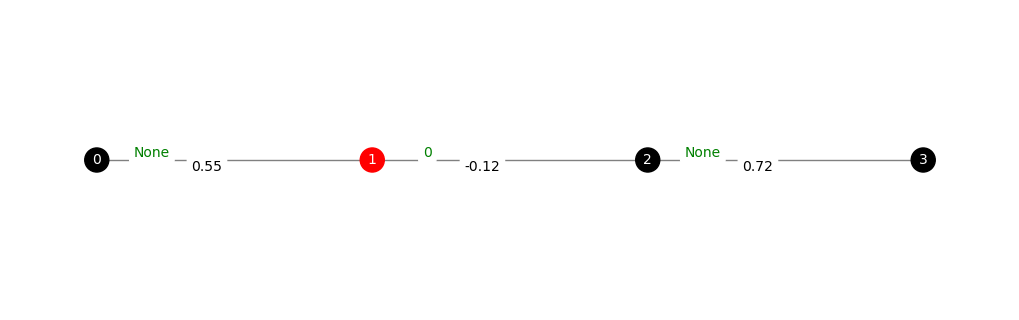

In [6]:
rng = np.random.default_rng(42)
Js = rng.uniform(-1, 1, size=n_qubits - 1)

G = get_graph(n_qubits, Js)
positions = get_positions(n_qubits)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

上の図で、
- 丸はスピンを表し、量子回路を実行するときには量子ビットとしてマップされる
- 赤い丸は、GHZ 部分の最初にアダマールゲートが作用する量子ビットである
- エッジの緑の数字は、GHZ 部分で CNOT が作用する順番である。効率的にエンタングルメントが広がるように、アダマールゲートが作用した量子ゲートから順に CNOT をかけていく。GHZ 部分で用意したい状態は $\ket{00111100}$ (中心半分が 1) なので、CNOT が作用する量子ビットは中心の半分である。'None' はそれ以外、つまり CNOT が作用されず、0 のままであることを表す
- エッジの黒の数字は、相互作用強度 $J_{ij}$ を表す。「ランダムなハミルトニアンを作る」とは、これらの $J_{ij}$ をランダムに作ることを意味する。

## データセットの作成

教師あり学習用のデータセット、すなわち input と output が組になったデータセットを作る。

input: Hamiltonian $H$

output: $y(H)=\operatorname{Tr}[f(H)\rho]$

今回は
- $f(H)=e^{-\beta H}$
- $\rho$ は純粋状態 $\rho=\ket{\psi}\bra{\psi}, \ket{\psi}=\ket{0011\cdots1100}$ (真ん中半分が 1, それ以外は 0)

とする。すなわち

output: $y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$

となる。以下ではまず、$\ket{\psi}=\ket{0011\cdots1100}$ を作成する。

In [7]:
# State |0011...1100> (center qubits are 1 and the rest are 0)
leftmost = n_qubits // 4
rightmost = leftmost + n_qubits // 2 - 1
index = []
for i in range(n_qubits):
    if leftmost <= i <= rightmost:
        index.append("1")
    else:
        index.append("0")

index = "".join(index)
state = Statevector.from_label(index)

print(
    f"entry of index {index} ({int(index, 2)} in decimal) for psi state: {state[int(index, 2)]}"
)

entry of index 0110 (6 in decimal) for psi state: (1+0j)


次に、$y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$ を厳密対角化で計算してデータセットを作る。

In [ ]:
data = []
graphs = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModel(n_qubits, G)

    H = heisenberg.H

    # state is big endian, so we need to reverse the qubits of the Hamiltonian
    H = Operator(H).reverse_qargs().to_matrix()
    H = scipy.sparse.csr_matrix(H)

    fH = scipy.sparse.linalg.expm(-beta * H)
    # Compute the expectation value <state|exp(-beta*H)|state>
    y = np.vdot(state, fH @ state).real

    data.append({"Js": Js, "expected_value": y})
    graphs.append(G)

df = pd.DataFrame(data)
display(df)
df["expected_value"].describe()

# json に保存 (orient="records" で行ごとに保存)
df.to_json(f"results/get_dataset/{n_qubits}Q_dataset.json", orient="records", indent=4)

Sample 0/55
Sample 1/55
Sample 2/55
Sample 3/55
Sample 4/55
Sample 5/55
Sample 6/55
Sample 7/55
Sample 8/55
Sample 9/55
Sample 10/55
Sample 11/55
Sample 12/55
Sample 13/55
Sample 14/55
Sample 15/55
Sample 16/55
Sample 17/55
Sample 18/55
Sample 19/55
Sample 20/55
Sample 21/55
Sample 22/55
Sample 23/55
Sample 24/55
Sample 25/55
Sample 26/55
Sample 27/55
Sample 28/55
Sample 29/55
Sample 30/55
Sample 31/55
Sample 32/55
Sample 33/55
Sample 34/55
Sample 35/55
Sample 36/55
Sample 37/55
Sample 38/55
Sample 39/55
Sample 40/55
Sample 41/55
Sample 42/55
Sample 43/55
Sample 44/55
Sample 45/55
Sample 46/55
Sample 47/55
Sample 48/55
Sample 49/55
Sample 50/55
Sample 51/55
Sample 52/55
Sample 53/55
Sample 54/55


,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",13.899220
1,"[0.3947360581187278, -0.8116453042247009, 0.95...",28.585213
2,"[0.5222794039807059, 0.5721286105539076, -0.74...",2.653082
3,"[-0.09922812420886573, -0.25840395153483753, 0...",7.222891
4,"[0.2877302401613291, 0.64552322654166, -0.1131...",0.865078
5,"[-0.5455225564304462, 0.1091695740316696, -0.8...",1.138950
6,"[0.6552623439851641, 0.2633287982441297, 0.516...",9.060659
7,"[-0.2909480637402633, 0.9413960487898065, 0.78...",4.367027
8,"[0.5567669941475237, -0.6107225842960649, -0.0...",4.566077
9,"[-0.9123924684255424, -0.6914210158649043, 0.3...",3.720380
